# Gradient Boosting Machines

### Conceptual Overview & Hyperparameter Tuning with xgboost

**Objectives**:
1. Understand the basic mathematical framework behind gradient boosted trees and the model's key hyperparameters
2. Understand the typical use cases for gradient boosting and some of the pros and cons
3. Build familiarity with the widely used xgboost package and practice selecting/tuning hyperparameters 

### Mathematical Framework

**First Pass (Regression)**:

Let's start by briefly returning to random forests. With the RF algorithm, we start with a very low bias but high variance **strong learner**, and reduce its variance by averaging across many relatively uncorrelated copies. Recall that we get these copies by injecting randomness into each base tree in the forest ensemble (taking bootstrapped samples of the training data, subsampling the feature columns for each tree split). The end result is a model that overfits less than a single decision tree due to variance reduction. See the diagram from [KDnuggets](https://www.kdnuggets.com/2017/10/random-forests-explained.html) below.

![](RFDiagram.jpg)

Boosting models are a flipped version of this paradigm. Instead of a strong learner, we start with a high bias but low variance **weak learner** and reduce its bias by training models that iteratively correct for the mistakes made by previous models. Building a sort of tower of weak models in this fashion makes for a strong ensemble that doesn't underfit, and the low variance of each base model helps insulate the ensemble from overfitting.

The most powerful variety of boosting in modern ML is **gradient boosted trees**, which we'll focus on. Our base learner is a simple decision tree with relatively small depth / few decision splits. We will build a final model by adding the results of many such trees together. The most intuitive problem setting to start with here is regression, with the usual sum of the squared errors (SSE) as the loss function we aim to minimize for data $X, y$. In each step of model building, we fit a base learner tree to the residuals of the current model's training predictions, adding it to the ensemble and gradually decreasing our training error. 

In (mostly) english, here's what we do:

* We'll train $k$ (hyperparameter) base learner decision trees with max depth $d$ (hyperparameter) step by step, adding each to our overall model.
* Each base tree is fit using our data $X$, but the target values are the residuals $y - model_{cur}$, where $model_{cur}$ is our overall model at that time step (sum of previous trees and initialization)  
* We initialize our model with the best constant prediction, $mean(y)$.   

As an algorithm:

1. Set $T_0 = mean(y)$
2. For $m = 1,...,k$:
    1. Set $r_{m-1} = y - (T_0 + \sum\limits_{j=1}^{m-1}T_j(X))$
    2. Fit max depth $d$ tree $T_m$ with features $X$, target $r_{m-1}$
  
Obtain final model: $F(X) = T_0 + T_1(X) + ... + T_k(X)$

![](RegressDiagram.png)

Not too complicated! But hold on, where does the *gradient* part of the name come in? And would we be able to adapt this model to a classification problem? As it turns out, the answer to both questions is the same. 

**Generalizing GBM to Differentiable Loss Functions**:

Yep, the **gradient** bit is closely related to the gradient descent algorithm that we know and love. It's also where the real power of the GBM framework becomes apparent. With the more general version of the algorithm that we'll see below, we can simply plug in a differentiable loss function and get an appropriate model.

To understand the general approach, consider the prediction values $F(X)$ that approximate the target $y$ for an arbitrary model $F$. Without putting any constraints on the function $F$, we could choose a differentiable loss function $L(y_{true},y_{pred})$ and define the model that minimizes it:

$$F_* = argmin_{F}L(y,F(X))$$

But since our loss function $L$ is differentiable, we can solve this problem by using iterative gradient descent on an element-wise basis:

$$F_{m+1}(x_i) = F_m(x_i) - \alpha\nabla{L(y_i,F_m(x_i))}$$ 

There's a clear problem here. All we're doing above is adjusting each predicted $y_i$ value until it gets increasingly close to the true $y_i$, meaning that we're memorizing the training data and overfitting. To not overfit, we have to introduce some constraint that forces generalization. In this case, instead of using the pure gradient, we'll model the gradient at each step with a regression tree $T_{m+1}$, fit on $X$ as features and the individual gradients $-\frac{\partial{L(y_{i},F_{m-1}(x_i))}}{\partial{F_{m-1}(x_i)}}$ as targets. Doing this, we can modify the gradient descent update rule so that it becomes:

$$F_{m+1}(x_i) = F_m(x_i) + T_{m+1}(x_i)$$

This looks exactly like the algorithm we used for regression boosting. It seems a bit fancier than what we had earlier, but really the only difference is that we've substituted gradient terms (**pseudo-residuals**) for the simple residuals we had originally. In fact, for SSE regression as above the gradient terms are equal to the residuals, so it's simply a special case of this general version of boosting. And with this single change we've expanded from being able to model least squares regression problems to being able to model for any differentiable loss function.    

Here is our generalized algorithm:

1. Choose loss function $L(y_{true},y_{pred})$
2. Initialize with best constant prediction i.e. $F_0 = argmin_{\gamma}\sum\limits_{i=1}^{N}L(y_i,\gamma)$
2. For $m = 1,...,k$:
    1. For $i = 1,...,n$: Set $r_{m-1,i} = -\frac{\partial{L(y_{i},F_{m-1}(x_i))}}{\partial{F_{m-1}(x_i)}}$
    2. Fit max depth $d$ tree $T_m$ with features $X$, target $r_{m-1}$
    3. Update $F_m(x) = F_{m-1}(x) + T_m(x)$
  
Obtain final model: $F(X) = T_0 + T_1(X) + ... + T_k(X)$

Note that we adapt to $k > 2$ class classification problems by training k of these models using [softmax loss](https://www.kdnuggets.com/2016/07/softmax-regression-related-logistic-regression.html). 

### Pros and Cons of GBMs

Boosted tree models are often the gold standard for tabular data in modern machine learning. They are well-equipped to model complex ground-truth functions without overfitting, adapt to your loss function of choice, and scale well to large datasets. They tend to do quite well with messy data: tree methods handle missing values naturally and can filter out the least useful input variables based on feature selection for splitting. That said, they are usually more sensitive to hyperparameter choice than random forests and can be a bit tricky and time-consuming to tune. They also lack the explicit interpretability of simpler models like linear/logistic regression.

In short, GBMs are a powerful tool to apply to a wide range of datasets (in terms of loss objective, size, variable types, and messiness). They are probably the closest thing to a catch-all and out-of-the-box modeling approach that currently exists. In a use case where you have at least a reasonable amount of data, want an optimally predictive model, can sacrifice some interpretability, and have the time/resources to tune multiple hyperparameters, you should definitely try a GBM model.   

![](xgbcalm.png)

**Summary**

**Pros**:

* Adaptable to wide range of problem settings (regression, classification, unusual or custom loss functions)
* Potential to be highly expressive (model compex, non-linear relationships)...
* But still flexible enough to accomodate complexity constraints/regularization  

*General tree benefits:*

* Feature scale invariant / natural handling of heterogenous features
* Automatic handling of missing/NA values 
* Automatic feature interaction
* Robust to input outliers and unhelpful input features (automatic feature selection)
* Scales well to large datasets

**Cons**:

* Many hyperparameters to tune for full power -- can be time-consuming and cause overfitting if not well-validated
* Lack clear/clean interpretability
* Tree methods struggle with extrapolation (can perform poorly on feature values outside of training range) 
* Can struggle with handling categorical variables (especially if large # of categories)

### Hands on GBMs and parameter tuning

Now that we've covered some of the theory behind GBMS and their pros and cons, let's turn to a concrete example of training one. We'll use [xgboost](https://github.com/dmlc/xgboost) (extreme gradient boosting), currently the most popular python package when it comes to training production-level boosting models. 

Another popular option is Microsoft's [lightgbm](https://github.com/Microsoft/LightGBM) package, which is  faster and sometimes more accurate than xgboost, but typically harder to tune and closer to bleeding edge as software. Sci-kit learn does have an easier to use [gbm implementation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), but it's less efficient and less powerful.

Xgboost makes some adjustments to the algorithm described above and introduces a number of powerful efficiencies that allow the package to scale well. [This post](https://medium.com/@Synced/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283) is a good overview comparison of classic gradient boosting and xgboost, and the [xgboost paper](https://arxiv.org/pdf/1603.02754.pdf) digs into methodology and implementation details.

For this example we'll use the California housing dataset that we've seen before (regression on housing prices). We'll first look at a couple of benchmarks, then step through the process of tuning an xgboost model and see what it can do. The process would be essentially the same for a classification problem (part of what makes boosting so great), which we'll see in a quick example at the end on the Wisconsin breast cancer dataset.

In [1]:
#Run this in command line, and come back to it later if issues, can be a bit tricky to install
#conda install -c conda-forge xgboost 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb
from sklearn.datasets import california_housing

housing_dataset = california_housing.fetch_california_housing()
X = pd.DataFrame(housing_dataset.data)
X.columns = housing_dataset.feature_names
y = housing_dataset.target

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
X.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2019)

#Evaluate models with Root Mean Squared Error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

Linear regression benchmark:

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)
rmse(lr.predict(X_test), y_test)

/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.7308026104606062

Random forest benchmark:

In [6]:
rf = RandomForestRegressor(n_estimators = 1000, max_features = 3, min_samples_leaf = 4, n_jobs=4)
rf.fit(X_train,y_train)
rmse(rf.predict(X_test), y_test)

0.5137219597585382

**Xgboost Tuning**

Now that we've set a solid baseline, let's turn to xgboost. Most of the parameters we'll use here should be familiar from the first section of this notebook or similar to what we've seen for random forests, with the exception of *learning rate*.

**n_estimators**: number of base learner trees  
**max_depth**: max depth per base tree (typical values are 3-12)   
**learning_rate**: shrinkage factor applied to each base tree update  
**subsample**: row subsampling rate (similar to RF)   
**min_child_weight**: roughly the minimum allowable child samples for a tree split to occur  
**colsample_bytree**: feature subsampling rate (similar to RF) 

The use of a learning rate/shrinkage factor is a form of regularization that can greatly reduce overfitting. It typically trades off with the n_estimators and depth parameters (raising these add complexity) -- lower learning rate  usually wants higher n_estimators, higher max depth usually wants lower learning rate etc. The two subsampling parameters and min_child_weight are also forms of regularization. These types of tradeoffs are part of why it typically works better to follow a manual tuning procedure than to try a massive grid search across different parameter combinations. That simply doesn't scale well to large datasets. 

Instead of trying to pick n_estimators by hand or do an intensive grid search, we'll use the **early stopping** technique as a massive time saver. This means that we track our validation error at each update step in the training process, and halt training once validation error hasn't improved in some number of **early_stopping_rounds**. This way, we can set n_estimators to a very large number and simply train until we land at a good stopping point for validation error. 

(One technical problem with early stopping is that n_estimators selection can overfit to the validation data. One reasonable solution is to combine early stopping with k-fold cross validation, and use the average n_estimators across k training rounds for training a new model).   

Here is our first xgboost example:

In [7]:
gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:linear",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,
                    verbose=True #gives output log as below
                   )

[0]	validation_0-rmse:1.78396	validation_1-rmse:1.79086
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:1.64256	validation_1-rmse:1.6493
[2]	validation_0-rmse:1.51563	validation_1-rmse:1.52422
[3]	validation_0-rmse:1.40291	validation_1-rmse:1.41306
[4]	validation_0-rmse:1.31244	validation_1-rmse:1.32405
[5]	validation_0-rmse:1.23505	validation_1-rmse:1.24772
[6]	validation_0-rmse:1.1635	validation_1-rmse:1.17625
[7]	validation_0-rmse:1.09205	validation_1-rmse:1.10604
[8]	validation_0-rmse:1.03186	validation_1-rmse:1.04658
[9]	validation_0-rmse:0.979518	validation_1-rmse:0.995347
[10]	validation_0-rmse:0.932689	validation_1-rmse:0.950492
[11]	validation_0-rmse:0.893962	validation_1-rmse:0.912157
[12]	validation_0-rmse:0.859459	validation_1-rmse:0.878444
[13]	validation_0-rmse:0.830449	validation_1-rmse:0.850065
[14]	validation_0-rmse:0.804211	validation_1-

[137]	validation_0-rmse:0.479199	validation_1-rmse:0.521849
[138]	validation_0-rmse:0.478787	validation_1-rmse:0.521694
[139]	validation_0-rmse:0.478624	validation_1-rmse:0.521806
[140]	validation_0-rmse:0.478382	validation_1-rmse:0.521714
[141]	validation_0-rmse:0.478015	validation_1-rmse:0.521278
[142]	validation_0-rmse:0.477437	validation_1-rmse:0.520728
[143]	validation_0-rmse:0.477079	validation_1-rmse:0.52058
[144]	validation_0-rmse:0.476301	validation_1-rmse:0.519882
[145]	validation_0-rmse:0.475653	validation_1-rmse:0.519395
[146]	validation_0-rmse:0.475007	validation_1-rmse:0.518818
[147]	validation_0-rmse:0.474719	validation_1-rmse:0.518748
[148]	validation_0-rmse:0.474362	validation_1-rmse:0.518588
[149]	validation_0-rmse:0.473793	validation_1-rmse:0.518165
[150]	validation_0-rmse:0.473498	validation_1-rmse:0.518067
[151]	validation_0-rmse:0.473279	validation_1-rmse:0.517894
[152]	validation_0-rmse:0.472683	validation_1-rmse:0.517326
[153]	validation_0-rmse:0.472478	validati

[274]	validation_0-rmse:0.439332	validation_1-rmse:0.501725
[275]	validation_0-rmse:0.439227	validation_1-rmse:0.501832
[276]	validation_0-rmse:0.439119	validation_1-rmse:0.501749
[277]	validation_0-rmse:0.43875	validation_1-rmse:0.501709
[278]	validation_0-rmse:0.438559	validation_1-rmse:0.501598
[279]	validation_0-rmse:0.43841	validation_1-rmse:0.501553
[280]	validation_0-rmse:0.43832	validation_1-rmse:0.501489
[281]	validation_0-rmse:0.438136	validation_1-rmse:0.501307
[282]	validation_0-rmse:0.437918	validation_1-rmse:0.501278
[283]	validation_0-rmse:0.437713	validation_1-rmse:0.501174
[284]	validation_0-rmse:0.43758	validation_1-rmse:0.501132
[285]	validation_0-rmse:0.437375	validation_1-rmse:0.501165
[286]	validation_0-rmse:0.436948	validation_1-rmse:0.501105
[287]	validation_0-rmse:0.436766	validation_1-rmse:0.500978
[288]	validation_0-rmse:0.436614	validation_1-rmse:0.500815
[289]	validation_0-rmse:0.436538	validation_1-rmse:0.500787
[290]	validation_0-rmse:0.436386	validation_

[411]	validation_0-rmse:0.416529	validation_1-rmse:0.493767
[412]	validation_0-rmse:0.416219	validation_1-rmse:0.493519
[413]	validation_0-rmse:0.415949	validation_1-rmse:0.49335
[414]	validation_0-rmse:0.415844	validation_1-rmse:0.493356
[415]	validation_0-rmse:0.415775	validation_1-rmse:0.493358
[416]	validation_0-rmse:0.415491	validation_1-rmse:0.49337
[417]	validation_0-rmse:0.415337	validation_1-rmse:0.493357
[418]	validation_0-rmse:0.415155	validation_1-rmse:0.493287
[419]	validation_0-rmse:0.415099	validation_1-rmse:0.49339
[420]	validation_0-rmse:0.414942	validation_1-rmse:0.493378
[421]	validation_0-rmse:0.414795	validation_1-rmse:0.49332
[422]	validation_0-rmse:0.414705	validation_1-rmse:0.493294
[423]	validation_0-rmse:0.414608	validation_1-rmse:0.493226
[424]	validation_0-rmse:0.414428	validation_1-rmse:0.493133
[425]	validation_0-rmse:0.414295	validation_1-rmse:0.493137
[426]	validation_0-rmse:0.414269	validation_1-rmse:0.493186
[427]	validation_0-rmse:0.414134	validation_

[549]	validation_0-rmse:0.39741	validation_1-rmse:0.487325
[550]	validation_0-rmse:0.397189	validation_1-rmse:0.487142
[551]	validation_0-rmse:0.39707	validation_1-rmse:0.487099
[552]	validation_0-rmse:0.396853	validation_1-rmse:0.48697
[553]	validation_0-rmse:0.39675	validation_1-rmse:0.486969
[554]	validation_0-rmse:0.396602	validation_1-rmse:0.48687
[555]	validation_0-rmse:0.396512	validation_1-rmse:0.486885
[556]	validation_0-rmse:0.396411	validation_1-rmse:0.486872
[557]	validation_0-rmse:0.39626	validation_1-rmse:0.486714
[558]	validation_0-rmse:0.39605	validation_1-rmse:0.486652
[559]	validation_0-rmse:0.395822	validation_1-rmse:0.486576
[560]	validation_0-rmse:0.395788	validation_1-rmse:0.48653
[561]	validation_0-rmse:0.395687	validation_1-rmse:0.486511
[562]	validation_0-rmse:0.395631	validation_1-rmse:0.486542
[563]	validation_0-rmse:0.395483	validation_1-rmse:0.486482
[564]	validation_0-rmse:0.395408	validation_1-rmse:0.486476
[565]	validation_0-rmse:0.395285	validation_1-rm

[687]	validation_0-rmse:0.382371	validation_1-rmse:0.484099
[688]	validation_0-rmse:0.382309	validation_1-rmse:0.484088
[689]	validation_0-rmse:0.382168	validation_1-rmse:0.484058
[690]	validation_0-rmse:0.382096	validation_1-rmse:0.484066
[691]	validation_0-rmse:0.382009	validation_1-rmse:0.483982
[692]	validation_0-rmse:0.38189	validation_1-rmse:0.48385
[693]	validation_0-rmse:0.381774	validation_1-rmse:0.483807
[694]	validation_0-rmse:0.381658	validation_1-rmse:0.483766
[695]	validation_0-rmse:0.381555	validation_1-rmse:0.483811
[696]	validation_0-rmse:0.38147	validation_1-rmse:0.483768
[697]	validation_0-rmse:0.381459	validation_1-rmse:0.48376
[698]	validation_0-rmse:0.381298	validation_1-rmse:0.483723
[699]	validation_0-rmse:0.381155	validation_1-rmse:0.483692
[700]	validation_0-rmse:0.381014	validation_1-rmse:0.483621
[701]	validation_0-rmse:0.380873	validation_1-rmse:0.483579
[702]	validation_0-rmse:0.380792	validation_1-rmse:0.483534
[703]	validation_0-rmse:0.380775	validation_

[824]	validation_0-rmse:0.369613	validation_1-rmse:0.480937
[825]	validation_0-rmse:0.369534	validation_1-rmse:0.480952
[826]	validation_0-rmse:0.369437	validation_1-rmse:0.48092
[827]	validation_0-rmse:0.369329	validation_1-rmse:0.480969
[828]	validation_0-rmse:0.369222	validation_1-rmse:0.481102
[829]	validation_0-rmse:0.369131	validation_1-rmse:0.481115
[830]	validation_0-rmse:0.369107	validation_1-rmse:0.481077
[831]	validation_0-rmse:0.368917	validation_1-rmse:0.480843
[832]	validation_0-rmse:0.36886	validation_1-rmse:0.48074
[833]	validation_0-rmse:0.36876	validation_1-rmse:0.480767
[834]	validation_0-rmse:0.368715	validation_1-rmse:0.480765
[835]	validation_0-rmse:0.36861	validation_1-rmse:0.480804
[836]	validation_0-rmse:0.368531	validation_1-rmse:0.480804
[837]	validation_0-rmse:0.368408	validation_1-rmse:0.480764
[838]	validation_0-rmse:0.368293	validation_1-rmse:0.480771
[839]	validation_0-rmse:0.368133	validation_1-rmse:0.480657
[840]	validation_0-rmse:0.368108	validation_1

[962]	validation_0-rmse:0.358441	validation_1-rmse:0.479726
[963]	validation_0-rmse:0.35839	validation_1-rmse:0.479711
[964]	validation_0-rmse:0.358303	validation_1-rmse:0.479708
[965]	validation_0-rmse:0.358161	validation_1-rmse:0.479734
[966]	validation_0-rmse:0.358064	validation_1-rmse:0.479765
[967]	validation_0-rmse:0.357989	validation_1-rmse:0.479749
[968]	validation_0-rmse:0.357972	validation_1-rmse:0.479727
[969]	validation_0-rmse:0.357848	validation_1-rmse:0.479679
[970]	validation_0-rmse:0.357767	validation_1-rmse:0.479646
[971]	validation_0-rmse:0.357716	validation_1-rmse:0.479649
[972]	validation_0-rmse:0.357625	validation_1-rmse:0.479632
[973]	validation_0-rmse:0.357534	validation_1-rmse:0.479701
[974]	validation_0-rmse:0.35744	validation_1-rmse:0.479617
[975]	validation_0-rmse:0.35729	validation_1-rmse:0.479622
[976]	validation_0-rmse:0.357145	validation_1-rmse:0.479561
[977]	validation_0-rmse:0.357077	validation_1-rmse:0.479632
[978]	validation_0-rmse:0.357027	validation

[1098]	validation_0-rmse:0.348007	validation_1-rmse:0.478426
[1099]	validation_0-rmse:0.347979	validation_1-rmse:0.478425
[1100]	validation_0-rmse:0.347895	validation_1-rmse:0.478417
[1101]	validation_0-rmse:0.34779	validation_1-rmse:0.478345
[1102]	validation_0-rmse:0.347755	validation_1-rmse:0.478343
[1103]	validation_0-rmse:0.347686	validation_1-rmse:0.478317
[1104]	validation_0-rmse:0.347606	validation_1-rmse:0.478323
[1105]	validation_0-rmse:0.347533	validation_1-rmse:0.478323
[1106]	validation_0-rmse:0.347474	validation_1-rmse:0.478298
[1107]	validation_0-rmse:0.34743	validation_1-rmse:0.478306
[1108]	validation_0-rmse:0.347342	validation_1-rmse:0.47825
[1109]	validation_0-rmse:0.347282	validation_1-rmse:0.478253
[1110]	validation_0-rmse:0.347214	validation_1-rmse:0.478234
[1111]	validation_0-rmse:0.347139	validation_1-rmse:0.478224
[1112]	validation_0-rmse:0.3471	validation_1-rmse:0.478213
[1113]	validation_0-rmse:0.347037	validation_1-rmse:0.478232
[1114]	validation_0-rmse:0.34

[1233]	validation_0-rmse:0.337585	validation_1-rmse:0.47712
[1234]	validation_0-rmse:0.337577	validation_1-rmse:0.47714
[1235]	validation_0-rmse:0.337513	validation_1-rmse:0.477186
[1236]	validation_0-rmse:0.337451	validation_1-rmse:0.477212
[1237]	validation_0-rmse:0.337372	validation_1-rmse:0.4772
[1238]	validation_0-rmse:0.337336	validation_1-rmse:0.477195
[1239]	validation_0-rmse:0.337254	validation_1-rmse:0.477218
[1240]	validation_0-rmse:0.337089	validation_1-rmse:0.477154
[1241]	validation_0-rmse:0.336995	validation_1-rmse:0.477158
[1242]	validation_0-rmse:0.33697	validation_1-rmse:0.477139
[1243]	validation_0-rmse:0.336924	validation_1-rmse:0.477151
[1244]	validation_0-rmse:0.336798	validation_1-rmse:0.477091
[1245]	validation_0-rmse:0.336731	validation_1-rmse:0.477124
[1246]	validation_0-rmse:0.336637	validation_1-rmse:0.47712
[1247]	validation_0-rmse:0.336469	validation_1-rmse:0.476939
[1248]	validation_0-rmse:0.336372	validation_1-rmse:0.476939
[1249]	validation_0-rmse:0.336

Starting xgb benchmark: we've already improved on RF.

In [8]:
# predict using n_estimators with lowest validation error
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

0.4765491266764797

To tune, we should use validation results and ignore test until final verification. So here's the validation error benchmark we want to beat:

In [9]:
rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 

0.47649959015879567

We'll approach tuning using this general framework, starting from the original parameters:

1. Tune max_depth
2. Tune subsample
3. Tune min_child_weight
4. Tune colsample_bytree
5. Set learning_rate to .05 and use early stopping to get n_estimators

There are even more [xgboost parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md) such as regularization terms that are worth tuning, but this framework should be a starting point for solid parameters.

For this process we'll repeat the cell block below with each adjustment and track our progress with comments, and tune in this way: say for max_depth, starting from 3 we try 5, 7 etc. until we stop improving then narrow down the search space. 

In [10]:
#Step by step RMSEs, with .1 learning rate:
#best max_depth: 7, .4487
#best subsample: .8, .447
#best min_child_weight: 12, .4463
#best colsample_bytree: .8, .4463 where we had it
#With learning_rate set to .05, get .4438 RMSE

gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=7,
                       objective="reg:linear",
                       learning_rate=.05, 
                       subsample=.8,
                       min_child_weight=12,
                       colsample_bytree=.8
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,
                    verbose=False
                   )
rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 

0.44335267941081163

And our test MSE as a result of this process, a ~10% reduction in RMSE from the random forest model:

In [11]:
rmse(gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit),y_test) 

0.45700238768951545

**Challenge**

If you'd like to challenge yourself to get more proficient with xgboost, try tuning this model even more and beat our current score. Do some research into other xgboost parameters that you could try using. I'd recommend l1, l2, and gamma regularization terms. 

**Interpretation**

When trying to interpret a boosting model, we're faced with a similar challenge to that of interpreting a RF model. Many people would refer to it as a "black box" model. Luckily, there are some readily available ways to better understand feature importances and impacts on the model.  

The easiest method is very similar to RF feature importances. We can assign importance scores to features in a number of different ways, and xgboost lets us easily plot/extract these scores. The most common scoring methods are **frequency** (default, just calculates the # of total tree splits the feature is used in), and **gain** (probably better, calculates cumulative information gain from tree splits done on that feature).

As we can see in the charts below, the two methods tend to agree on which features are most important. However, gain views Median Income as much more important than any of the other features, which seems like a reasonable conclusion.  

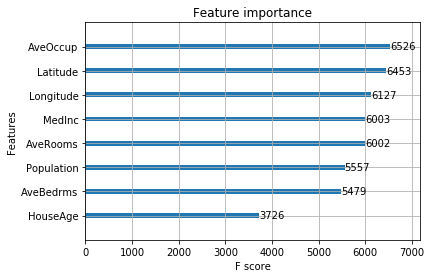

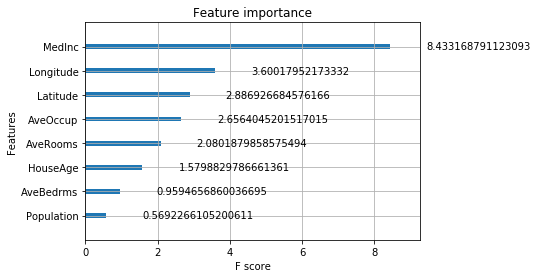

In [12]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

In [13]:
gbm.booster().get_score(importance_type='weight') #extract raw frequency scores

{'AveBedrms': 5479,
 'AveOccup': 6526,
 'AveRooms': 6002,
 'HouseAge': 3726,
 'Latitude': 6453,
 'Longitude': 6127,
 'MedInc': 6003,
 'Population': 5557}

In [14]:
gbm.booster().get_score(importance_type='gain') #extract raw gain scores

{'AveBedrms': 0.9594656860036695,
 'AveOccup': 2.6564045201517015,
 'AveRooms': 2.0801879858575494,
 'HouseAge': 1.5798829786661361,
 'Latitude': 2.886926684576166,
 'Longitude': 3.60017952173332,
 'MedInc': 8.433168791123093,
 'Population': 0.5692266105200611}

A key problem with importance scores is that they only tell us which features are most relevant, not what the directional impact of the feature is on the model/target. Techniques have been developed to visually study these impacts that include [Partial Dependence](http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html) and [Individual Conditional Expectation](https://arxiv.org/pdf/1309.6392.pdf) plots, but these are beyond the scope of this lecture.

**Classification Example**

Breast cancer dataset (binary classification). Boosting does not seem to work that well on this problem (unsuprising given a small sample size of <600). But this shows how we can apply xgboost to a classification problem by simply changing the objective and eval_metric parameters.

In [15]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score

bc_dataset = load_breast_cancer()
X = pd.DataFrame(bc_dataset.data)
X.columns = bc_dataset.feature_names
y = bc_dataset.target

#Split data into 3: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [16]:
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_val,y_val)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit)) 

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.9473684210526315